### IMPORTING PACKAGES

In [2]:
# Only for internal processing

# import os, ssl
# os.environ['CURL_CA_BUNDLE'] = '/etc/pki/ca-trust/extracted/openssl/ca-bundle.trust.crt'
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /home/bruce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bruce/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/bruce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Data

In [5]:
#you can download the data from https://www.kaggle.com/c/nlp-getting-started/data
import os
os.chdir('./Dataset/SixClass/')
df_train=pd.read_csv('train.csv')
print(df_train.shape)
df_train.head()

(28623, 4)


,Unnamed: 0,text,label,target
0,38746,#trumprussia sean spicer is a blithering idiot...,Others,4
1,47265,If you call yourself a Christian yet you suppo...,Religion,5
2,36632,Small red lights in dark rooms.,Others,4
3,29064,If u find yourself pouting that no male report...,Notcb,3
4,33884,Messi carried these retards to three consecuti...,Others,4


## EDA

<class 'pandas.core.series.Series'>
0    4878
5    4821
2    4782
1    4749
3    4707
4    4686
Name: target, dtype: int64


<Axes: ylabel='target'>

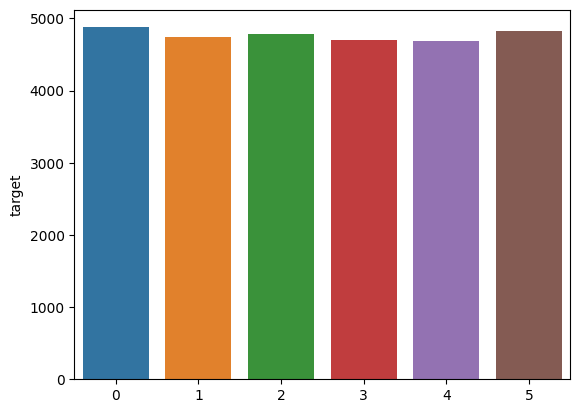

In [6]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['target'].value_counts()
print(type(x))
print(x)
sns.barplot(x=x.index, y=x)

In [13]:
#Remove old index
#del df_train['Unnamed: 0']

#Missing values
print(df_train.isna().sum())
df_train

text      0
label     0
target    0
dtype: int64


,text,label,target
0,#trumprussia sean spicer is a blithering idiot...,Others,4
1,If you call yourself a Christian yet you suppo...,Religion,5
2,Small red lights in dark rooms.,Others,4
3,If u find yourself pouting that no male report...,Notcb,3
4,Messi carried these retards to three consecuti...,Others,4
...,...,...,...
28618,@TheWolfieGirl Kill niggers #KKK hold up BITCH...,Ethnicity,1
28619,She 5'7 and her bf 4'7 lmao,Notcb,3
28620,ha she got sand in her vagina RT @tayyoung_ FU...,Ethnicity,1
28621,"Just a reminder, it's absolutely disgusting to...",Ethnicity,1


In [22]:
trt_dict = { 0:'Age', 1:'Ethnicity', 2:'Gender', 3:'Notcb', 4:'Others', 5:'Religion'}

tgt_num = df_train['label'].nunique()
#print(tgt_num)


for trt in range(tgt_num):    
    print("The trait is ",trt_dict[trt], '\n')
    
    #1. WORD-COUNT
    df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
    print('word counts')
    print('trait ', trt_dict[trt], df_train[df_train['target']==trt]['word_count'].mean()) #Disaster tweets
    
    #2. CHARACTER-COUNT
    df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
    print('character counts')
    print('trait ',trt_dict[trt], df_train[df_train['target']==trt]['char_count'].mean()) #Disaster tweets
   
    #3. UNIQUE WORD-COUNT
    df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
    print('unique word-counts')
    print('trait ',trt_dict[trt], df_train[df_train['target']==trt]['unique_word_count'].mean()) #Disaster tweets
    
    print('\n')

The trait is  Age 

word counts
trait  Age 32.24251742517425
character counts
trait  Age 173.05678556785568
unique word-counts
trait  Age 28.625461254612546


The trait is  Ethnicity 

word counts
trait  Ethnicity 24.90840176879343
character counts
trait  Ethnicity 139.46157085702254
unique word-counts
trait  Ethnicity 22.723520741208677


The trait is  Gender 

word counts
trait  Gender 23.72814721873693
character counts
trait  Gender 137.13697197825178
unique word-counts
trait  Gender 21.666666666666668


The trait is  Notcb 

word counts
trait  Notcb 13.560229445506693
character counts
trait  Notcb 82.5882727852135
unique word-counts
trait  Notcb 13.006373486297004


The trait is  Others 

word counts
trait  Others 13.95134443021767
character counts
trait  Others 84.89714041826718
unique word-counts
trait  Others 13.330132309005549


The trait is  Religion 

word counts
trait  Religion 33.45924082140635
character counts
trait  Religion 198.11325451151214
unique word-counts
trait  Re

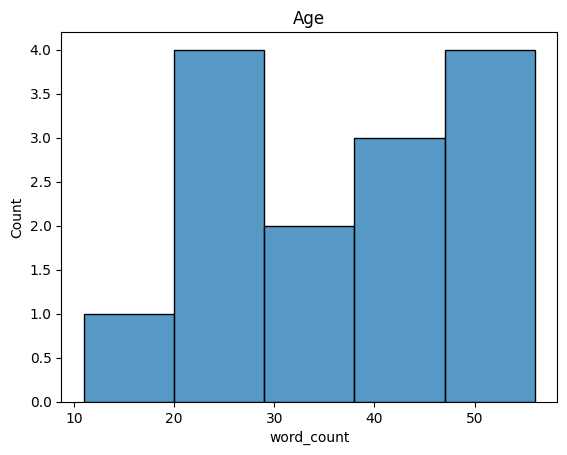

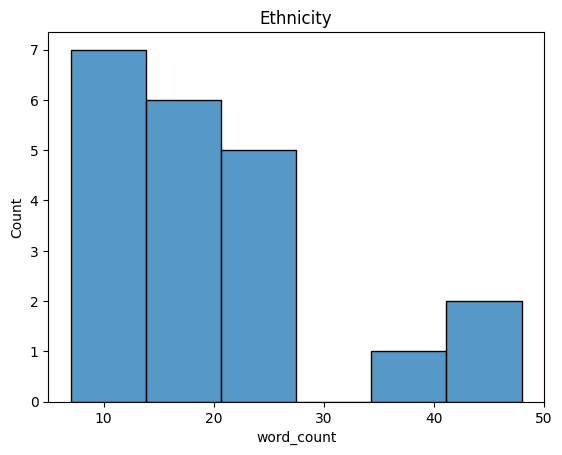

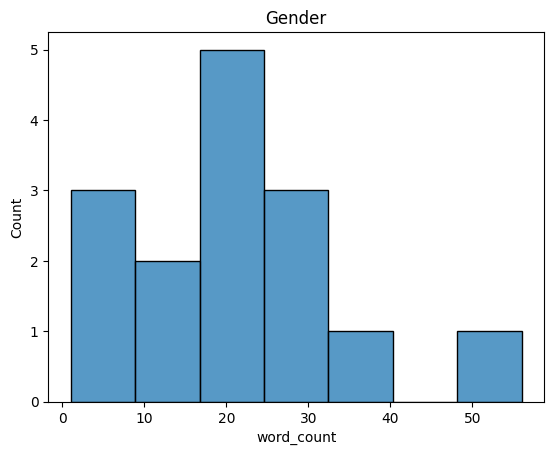

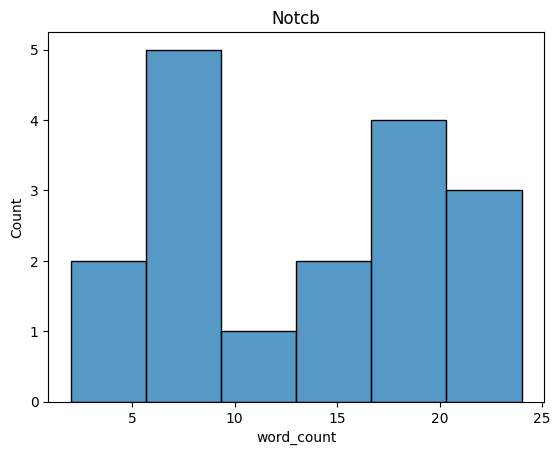

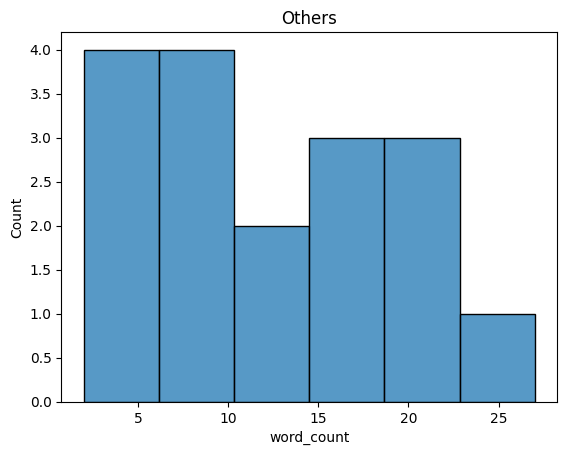

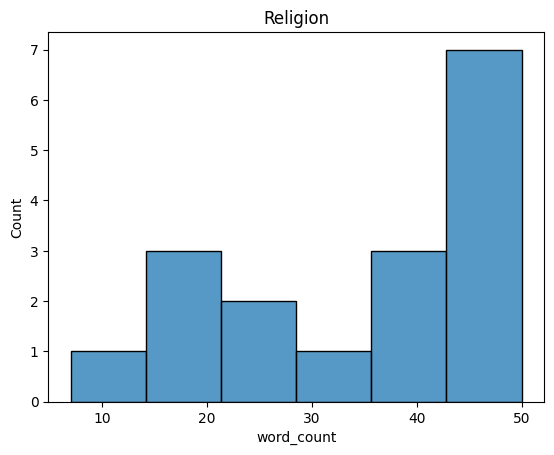

In [49]:
for trt in range(tgt_num):
    train_words=df_train[df_train['target']==trt]['word_count']
    train_words = train_words[train_words.index <= 100]
    
    #train_words = train_words['text'].str.len()<100]
    plt.figure(trt)
    sns.histplot(train_words).set(title=trt_dict[trt])
    

## PRE-PROCESSING

In [50]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/bruce/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

message cleaned may involve things like adjacent spaces tabs
messag clean may involv thing like adjac space tab
messag clean may involv thing like adjac space tab


In [53]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,text,label,target,clean_text
0,#trumprussia sean spicer is a blithering idiot...,Others,4,trumprussia sean spicer blither idiot repeat a...
1,If you call yourself a Christian yet you suppo...,Religion,5,call christian yet support bill man push asham...
2,Small red lights in dark rooms.,Others,4,small red light dark room
3,If u find yourself pouting that no male report...,Notcb,3,u find pout male reporter recognize one press ...
4,Messi carried these retards to three consecuti...,Others,4,messi carry retard three consecutive final unb...


### Word2Vec model

In [54]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


#w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector
#w2v = dict(zip(model.wv.index_to_key, model.wv.syn0))  #combination of word and its vector
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 
#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


### TRAIN TEST SPLITTING OF LABELLED DATASET

In [55]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["target"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

### Building ML models (Text-classification)

#### LR (tf-idf)

In [57]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))
 
# fpr, tpr, thresholds = roc_curve(y_val, y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       965
           1       0.97      0.98      0.98       957
           2       0.90      0.85      0.88       962
           3       0.58      0.54      0.56       948
           4       0.58      0.63      0.60       921
           5       0.96      0.94      0.95       972

    accuracy                           0.82      5725
   macro avg       0.82      0.82      0.82      5725
weighted avg       0.82      0.82      0.82      5725

Confusion Matrix:
 [[942   2   0  10  11   0]
 [  0 935   1   4  12   5]
 [  5   5 821  72  56   3]
 [ 32   8  41 516 322  29]
 [ 29   8  45 256 577   6]
 [  1   2   6  38  11 914]]


#### NB (tf-idf)

In [58]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
# fpr, tpr, thresholds = roc_curve(y_val, y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)  




              precision    recall  f1-score   support

           0       0.67      0.98      0.79       965
           1       0.86      0.90      0.88       957
           2       0.81      0.85      0.83       962
           3       0.69      0.36      0.48       948
           4       0.63      0.44      0.52       921
           5       0.81      0.96      0.88       972

    accuracy                           0.75      5725
   macro avg       0.74      0.75      0.73      5725
weighted avg       0.74      0.75      0.73      5725

Confusion Matrix: [[949   4   4   0   2   6]
 [ 52 857   5   0   8  35]
 [ 29  24 815  49  22  23]
 [171  34  93 343 207 100]
 [209  75  83  94 406  54]
 [ 13   6  11   8   2 932]]


#### LR (w2v)

In [59]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
# fpr, tpr, thresholds = roc_curve(y_val, y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       965
           1       0.91      0.95      0.93       957
           2       0.86      0.75      0.80       962
           3       0.55      0.45      0.49       948
           4       0.51      0.60      0.55       921
           5       0.90      0.94      0.92       972

    accuracy                           0.78      5725
   macro avg       0.77      0.77      0.77      5725
weighted avg       0.77      0.78      0.77      5725

Confusion Matrix: [[919   5   4  24  12   1]
 [  3 912   2   7  24   9]
 [  5  12 723 105 106  11]
 [ 54  19  44 425 356  50]
 [ 44  48  56 191 549  33]
 [  1   6  10  23  20 912]]


### TESTING THE MODEL ON UNLABELLED DATASET

In [60]:
#Testing it on new dataset with the best model
df_test=pd.read_csv('test.csv')  #reading the data
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
print(df_test.head())
final=df_test[['id','target']].reset_index(drop=True)
final.to_csv('submission.csv')

   Unnamed: 0                                               text      label  \
0       24948                  @hestiahdruid are those any good?      Notcb   
1       12778        Saw My Lil'Nigga @DopeShitt__ Dis Mawning !  Ethnicity   
2       40623  Hey @ImranKhanPTI how are you feeling after be...   Religion   
3       39427                              @Tilaurin probably :P     Others   
4       41816  Shameful really....you are defending ordinary ...   Religion   

   target                                         clean_text  predict_prob  
0       4                                  hestiahdruid good      0.004287  
1       1                saw lil nigga dopeshitt dis mawning      0.595758  
2       5  hey imrankhanpti feel become slave chinese dar...      0.007820  
3       4                                tilaurin probably p      0.004658  
4       5  shameful really defend ordinary muslim oppress...      0.000670  


KeyError: "['id'] not in index"